# A2C on Mario

In [1]:
# Windows: first, install Visual Studio build tools
# pip install nes-py
# pip install gym-super-mario-bros

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

In [2]:
# Loading LegoRL library
import sys
sys.path.append('.\\src')  # path to folder with library
from LegoRL import *

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import gym

# Magic "Custom Reward"

In [4]:
# SOURCE: https://github.com/uvipen/Super-mario-bros-A3C-pytorch/blob/master/src/env.py
from gym.spaces import Box
from gym import Wrapper
import cv2
import numpy as np

class CustomReward(Wrapper):
    def __init__(self, env):
        super(CustomReward, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(1, 84, 84))
        self.curr_score = 0
    
    def process_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84, 84))[None, :, :] / 255.
        return frame
    
    def step(self, action):
        state, reward, done, info = self.env.step(action)
        
        state = self.process_frame(state)
        
        reward += (info["score"] - self.curr_score) / 40.
        self.curr_score = info["score"]
        if done:
            if info["flag_get"]:
                reward += 50
            else:
                reward -= 50
        return state, reward / 10., done, info

    def reset(self):
        self.curr_score = 0
        return self.process_frame(self.env.reset())


class CustomSkipFrame(Wrapper):
    def __init__(self, env, skip=4):
        super(CustomSkipFrame, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(4, 84, 84))
        self.skip = skip

    def step(self, action):
        total_reward = 0
        states = []
        state, reward, done, info = self.env.step(action)
        for i in range(self.skip):
            if not done:
                state, reward, done, info = self.env.step(action)
                total_reward += reward
                states.append(state)
            else:
                states.append(state)
        states = np.concatenate(states, 0)[:, :, :]
        return states.astype(np.float32), reward, done, info

    def reset(self):
        state = self.env.reset()
        states = np.concatenate([state for _ in range(self.skip)], 0)[:, :, :]
        return states.astype(np.float32)

# Environment

In [5]:
def create_env():
    def _thunk():
        env = gym_super_mario_bros.make('SuperMarioBros-v0')
        env = JoypadSpace(env, COMPLEX_MOVEMENT)             # we want 12 actions instead of 2^12
        env = CustomReward(env)
        env = CustomSkipFrame(env)
        return env
    return _thunk

In [6]:
env = create_env()()
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(4, 84, 84)
Action space: Discrete(12)


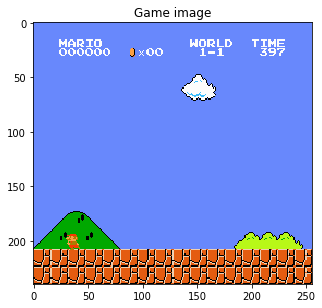

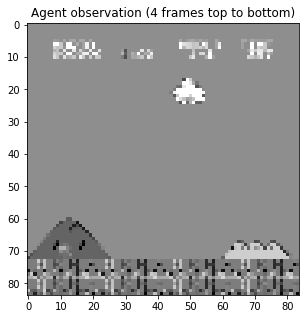

In [8]:
env.reset()
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[5,5])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[5,5])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs[-1], cmap='gray')
plt.show()

# Network

Network architecture is taken from curiosity article (nothing fancy).

In [9]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(*x.shape[:-3], -1)

class MarioNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),           
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(1152, 256),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        names = x.names
        x = x.rename(None)
        return self.layers(x).refine_names(*names[:-3], "features")

# Model

In [11]:
agent = Composed(
    visualizer   = Visualizer(),
    runner       = Runner(policy="policy", threads=8),
    player       = Player(policy="policy", timer=25000, records_file_name="videos/a2c", record_timer=25000),
    rollout      = RolloutCollector(runner="runner", rollout_length=5),
    backbone     = Backbone(MarioNN()),
    policy       = PolicyHead(backbone="backbone"),
    critic       = ValueHead(backbone="backbone"),
    maxtrace     = MaxTrace(evaluator="critic"),
    actor_loss   = ActorLoss(rollout="rollout", policy="policy", target="maxtrace", baseline="critic"),
    critic_loss  = CriticLoss(sampler="rollout", critic="critic", target="maxtrace"),
    entropy_loss = EntropyLoss(rollout="rollout", policy="policy"),
    trainer      = Trainer(backbone="backbone", losses=["actor_loss", "critic_loss", "entropy_loss"], weights=[1, 1, 0.01],
                          optimizer=torch.optim.Adam, optimizer_args={"lr": 0.0001}, clip_gradients=10)
)

In [12]:
system = System(agent, gamma=0.9, file_name="models/legorl_a2c", save_timer=50000, make_env=create_env)

..\c10/core/TensorImpl.h:864: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable.


runner: environment initialization... Finished.
Adding new head <policy> to <backbone>:
  Input shape is (4, 84, 84)
  Backbone feature size is 256
  Desired output is torch.Size([12])
Adding new head <critic> to <backbone>:
  Input shape is (4, 84, 84)
  Backbone feature size is 256
  Desired output is torch.Size([])


In [13]:
# loading model
system.load()

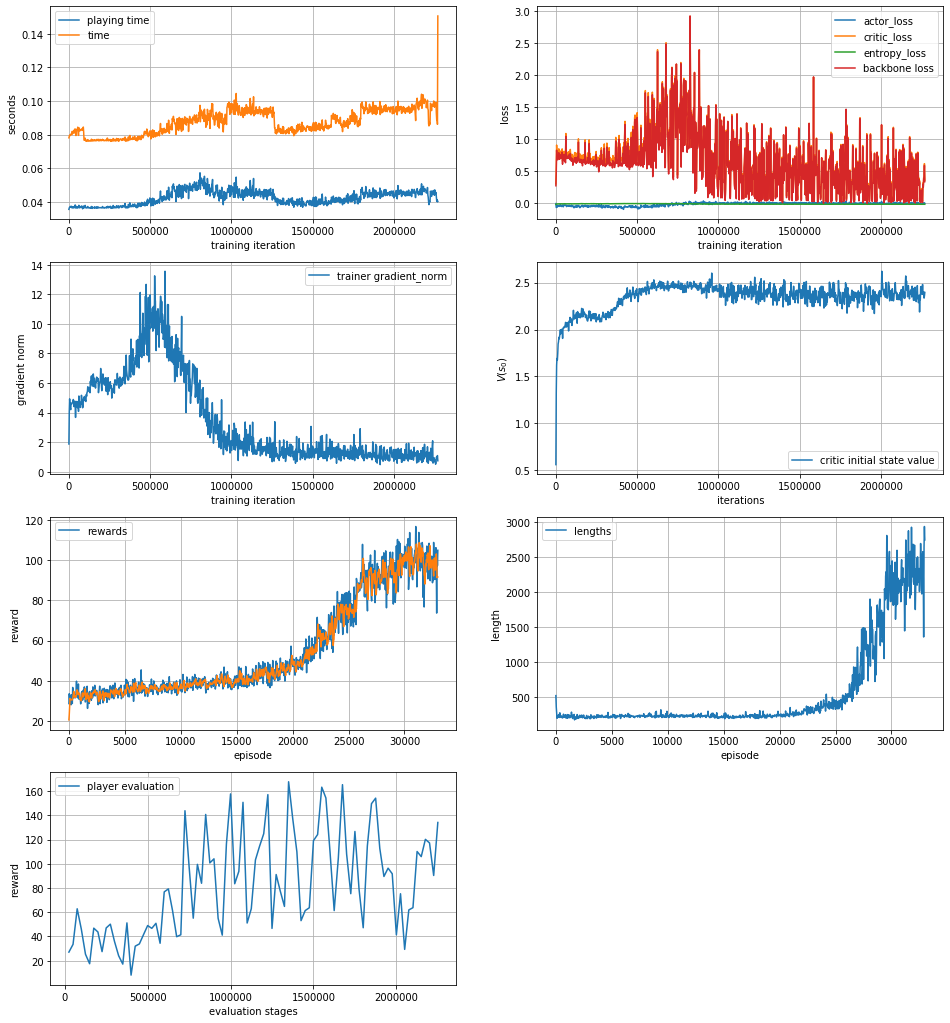

KeyboardInterrupt: 

In [13]:
system.run(10000000)

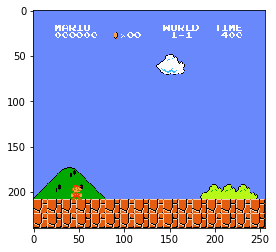

In [38]:
rollout = agent.player.play(render=True)

In [14]:
system.save()

# Learning statistics

In [16]:
print("Learning time in hours: ", sum(system.logger['time']) / 60 / 60)
print("Frames done: ", agent.runner.frames_done)
print("Fps: ", agent.runner.frames_done / sum(system.logger['time']))
print("Episodes played: ", agent.runner.episodes_done)

Learning time in hours:  55.20164153496424
Frames done:  18179840
Fps:  91.48198160659692
Episodes played:  33006


Text(0.5, 0, 'episode')

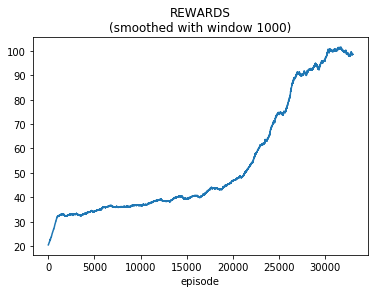

In [17]:
from LegoRL.utils.visualizer import sliding_average
plt.plot(sliding_average(system.logger['rewards'], 1000))
plt.title("REWARDS\n(smoothed with window 1000)")
plt.xlabel("episode")